# Import dependencies

In [1]:
!pip install torchinfo -q

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchvision.ops import Conv2dNormActivation
from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import pandas as pd
import requests
import random
import warnings
from tqdm import tqdm
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
# set seed for reproducibility

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

set_seed(42)

# Download and extract the dataset

In [4]:
!wget -q "https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1" -O "10_Monkey_Species.zip"
!unzip -q "10_Monkey_Species.zip"
print("Dataset downloaded and extracted successfully")

Dataset downloaded and extracted successfully


# Dataset and Training Configuration


In [5]:
@dataclass(frozen = True)
class TrainingConfig:

    """Configuration for training"""

    batch_size : int = 32
    num_epochs : int = 20
    learning_rate : float = 1e-4
    log_interval : int = 1
    test_interval : int = 1
    data_root : str = "./"
    num_workers : int = 5
    device : str = "cuda"

trainConfig = TrainingConfig()
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print(f"Using device : {device}")

Using device : cuda


## Load custom dataset in pyTorch


In [6]:
train_root = os.path.join("10_Monkey_Species","training","training")
val_root = os.path.join("10_Monkey_Species","validation","validation")

In [7]:
df = pd.read_csv(os.path.join("10_Monkey_Species","monkey_labels.txt"), sep = ",", header = 0)
df.columns = ["Label", "Latin Name", "Common Name", "Train Images", "Validation Images"]
df['Latin Name'] = df['Latin Name'].str.replace('\t', ' ')
df[1:]

,Label,Latin Name,Common Name,Train Images,Validation Images
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26
5,n5,cebus_capucinus,white_headed_capuchin,141,28
6,n6,mico_argentatus,silvery_marmoset,132,26
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


# Dataset preprocessing

In [8]:
mean = [0.4368, 0.4336, 0.3294]  # Mean pixel values for normalization (RGB channels)
std = [0.2457, 0.2413, 0.2447]  # Standard deviation pixel values for normalization (RGB channels)

img_size = (224,224)

preprocess = transforms.Compose([
    transforms.Resize(img_size, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [9]:
common_transforms = transforms.Compose([
    preprocess,
    transforms.Normalize(mean, std)
])

train_transforms = transforms.Compose([
    preprocess,
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomErasing(p = 0.5),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=(30,70), translate=(0.1,0.3), scale=(0.5,0.75))
    ], p = 0.75),
    transforms.Normalize(mean, std)
])


## Dataloader preparation

In [10]:
# apply augmentation
train_data = datasets.ImageFolder(root=train_root, transform = train_transforms)
val_data = datasets.ImageFolder(root=val_root, transform = common_transforms)
train_data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [11]:
train_data.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [12]:
len(train_data)

1097

In [13]:
# creating dataloader

train_loader = DataLoader(
    train_data,
    shuffle = True,
    batch_size = trainConfig.batch_size,
    num_workers = trainConfig.num_workers,
)

val_loader = DataLoader(
    val_data,
    shuffle = False,
    batch_size = trainConfig.batch_size,
    num_workers = trainConfig.num_workers,
)

In [14]:
#Map class names to class ids.
class_mapping = {

    0: "mantled_howler",
    1: "patas_monkey",
    2: "bald_uakari",
    3: "japanese_macaque",
    4: "pygmy_marmoset",
    5: "white_headed_capuchin",
    6: "silvery_marmoset",
    7: "common_squirrel_monkey",
    8: "black_headed_night_monkey",
    9: "nilgiri_langur"
}

## Display Images from the dataset

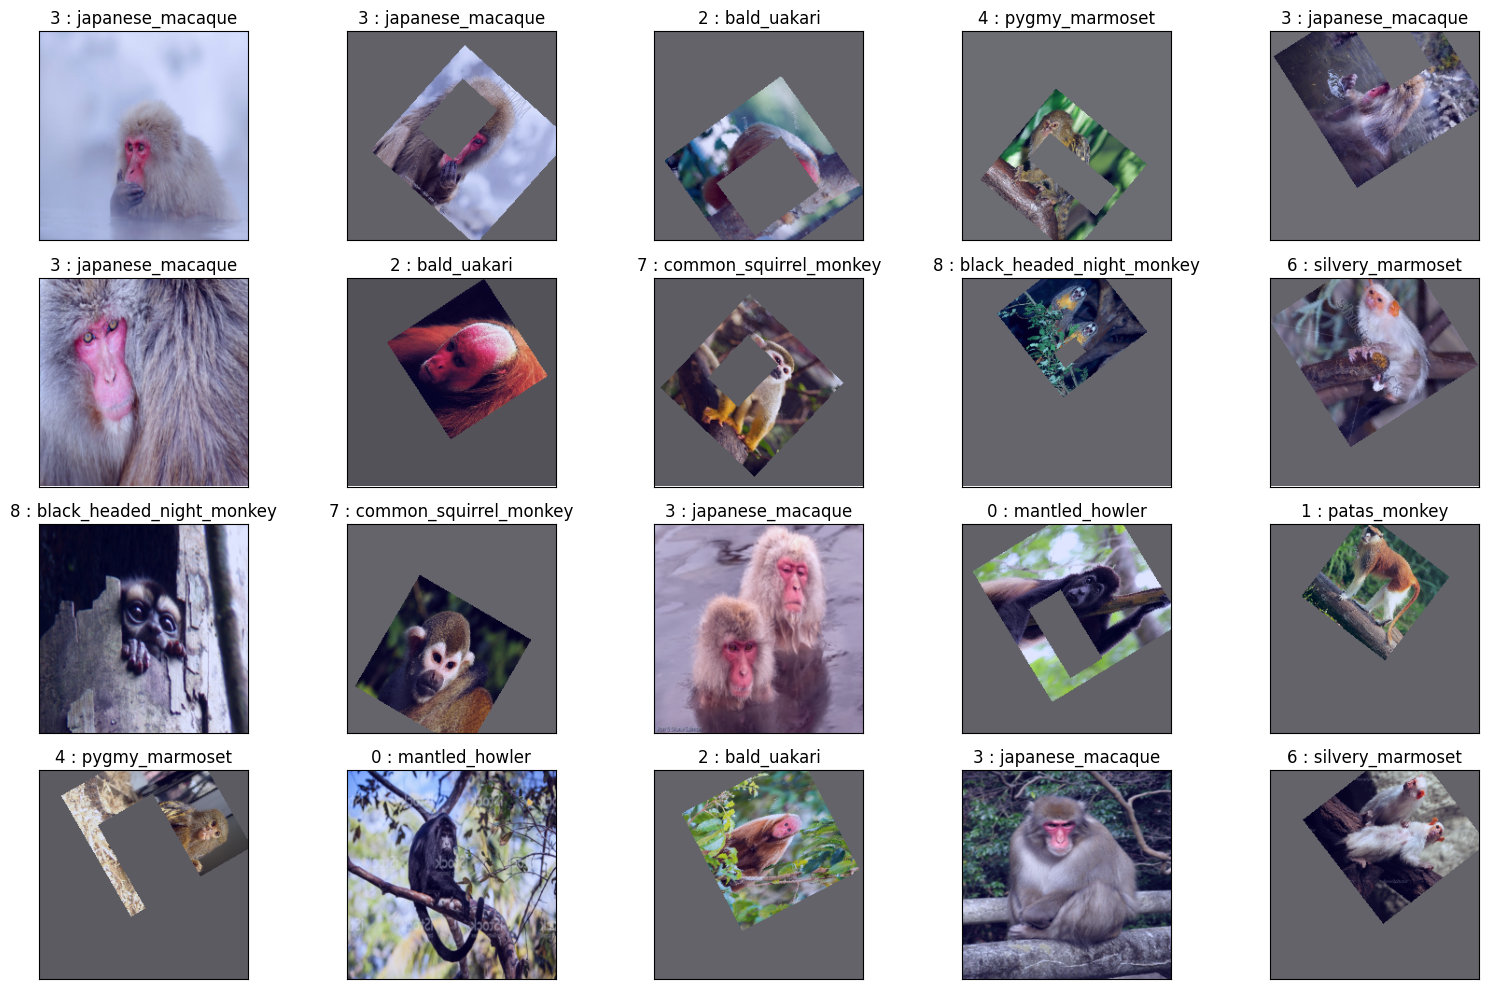

In [15]:
def visualize_images(dataloader, num_images = 20):

    fig = plt.figure(figsize = (16,10))
    images , labels = next(iter(dataloader))
    num_rows = 4
    num_cols = int(np.ceil((num_images/num_rows)))

    for idx in range(min(num_images, len(images))):
        image , label = images[idx] , labels[idx]
        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
        image = image.permute(1,2,0)
        image = (image - image.min())/(image.max() - image.min())
        ax.imshow(image, cmap = 'gray')
        ax.set_title(f"{label.item()} : {class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_images(train_loader)

# Fine tuning with pre trained model

In [16]:
from torchvision.models import mobilenet_v3_small

# load the model
mobilenetv3_model = mobilenet_v3_small(weights = "DEFAULT")
print()

# number of feature layers
num_feature_layers = len(mobilenetv3_model.features)
print(f"Number of feature layers: {num_feature_layers}")

# number of classifier layers
num_classifier_layers = len(mobilenetv3_model.classifier)
print(f"Number of classifier layers: {num_classifier_layers}")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 111MB/s]


Number of feature layers: 13
Number of classifier layers: 4


In [17]:
#Set requires_grad to True for all model parameters to allow training
# Freeze the earlier layers to retain pretrained low-level features
for param in mobilenetv3_model.features[:10].parameters():
    param.requires_grad = False

In [18]:
# Check the final classifier
print(mobilenetv3_model.classifier[3])

Linear(in_features=1024, out_features=1000, bias=True)


In [19]:
# Replace the final linear layer of the classifier to match the number of classes in the dataset
mobilenetv3_model.classifier[3] = nn.Linear(in_features = 1024, out_features = 10, bias = True)

# Check the final classifier after modifications
print(mobilenetv3_model.classifier[3])

model = mobilenetv3_model

Linear(in_features=1024, out_features=10, bias=True)


In [20]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr = trainConfig.learning_rate)

# device
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

# Tensorboard logs
logdir = "runs/mobilenetv3-Monkey-species"

# Summary Writer for details
writer = SummaryWriter(logdir)

# print model summary
summary(model, input_size = (1,3,224,224), row_settings=['var_names'], device="cpu")

Layer (type (var_name))                                      Output Shape              Param #
MobileNetV3 (MobileNetV3)                                    [1, 10]                   --
├─Sequential (features)                                      [1, 576, 7, 7]            --
│    └─Conv2dNormActivation (0)                              [1, 16, 112, 112]         --
│    │    └─Conv2d (0)                                       [1, 16, 112, 112]         (432)
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]         (32)
│    │    └─Hardswish (2)                                    [1, 16, 112, 112]         --
│    └─InvertedResidual (1)                                  [1, 16, 56, 56]           --
│    │    └─Sequential (block)                               [1, 16, 56, 56]           (744)
│    └─InvertedResidual (2)                                  [1, 24, 28, 28]           --
│    │    └─Sequential (block)                               [1, 24, 28, 28]           

# Model training and evaluation

In [21]:
def train(model, train_loader):
    """
    Trains the model for one epoch using the provided training data loader.

    Parameters:
    model (torch.nn.Module): The neural network model to be trained.
    train_loader (DataLoader): The DataLoader for training data.

    Returns:
    tuple: Average training loss and training accuracy.
    """

    model.train()
    model.to(device)

    running_loss = 0
    correct_predictions = 0
    total_train_samples = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device) , labels.to(device)
        output = model(images)
        loss = F.cross_entropy(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_predictions / total_train_samples

    return train_loss, train_accuracy

In [22]:
def validation(model, val_loader):
    """
    Evaluates the model performance using the provided validation data loader.

    Parameters:
    model (torch.nn.Module): The neural network model to be evaluated.
    val_loader (DataLoader): The DataLoader for validation data.

    Returns:
    tuple: Average validation loss and validation accuracy.
    """

    model.eval()
    model.to(device)

    running_loss = 0
    total_samples = 0
    correct_predictions = 0

    for images, labels in tqdm(val_loader, desc="Validation"):
        images, labels = images.to(device) , labels.to(device)

        with torch.inference_mode():
            output = model(images)

        loss = F.cross_entropy(output, labels)
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    accuracy = 100 * correct_predictions / total_samples

    return val_loss, accuracy

In [23]:
def main(model, train_loader, val_loader):
    """
    Trains and validates the model over multiple epochs.

    Parameters:
    model (torch.nn.Module): The neural network model to be trained and validated.
    train_loader (DataLoader): The DataLoader for training data.
    val_loader (DataLoader): The DataLoader for validation data.

    Returns:
    tuple: Lists of training and validation losses and accuracies.
    """

    train_losses , val_losses = [] , []
    train_accuracies , val_accuracies = [] , []

    best_val_acc = 0.0
    best_weights = None

    for epoch in range(trainConfig.num_epochs):
        start_time = time.time()

        train_loss, train_accuracy = train(model, train_loader)
        val_loss, val_accuracy = validation(model, val_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print training progress
        print(f"Epoch {epoch+1:0>2}/{trainConfig.num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Logging metrics to TensorBoard
        writer.add_scalar('Loss/train', train_loss)
        writer.add_scalar('Loss/val', val_loss)
        writer.add_scalar('Accuracy/train', train_accuracy)
        writer.add_scalar('Accuracy/val', val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_weights = model.state_dict()
            print(f"saving best model...")
            torch.save(best_weights, "best_model.pth")

        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch time: {epoch_time:.2f} seconds")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [24]:
train_losses , train_accuracies, val_losses, val_accuracies = main(model, train_loader, val_loader)

Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 01/20 - Train Loss: 2.2028, Train Accuracy: 21.06% - Val Loss: 1.9949, Val Accuracy: 40.44%
saving best model...
Epoch time: 30.90 seconds


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]


Epoch 02/20 - Train Loss: 1.8891, Train Accuracy: 42.94% - Val Loss: 1.4969, Val Accuracy: 63.24%
saving best model...
Epoch time: 29.93 seconds


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


Epoch 03/20 - Train Loss: 1.5587, Train Accuracy: 57.52% - Val Loss: 1.0816, Val Accuracy: 72.43%
saving best model...
Epoch time: 28.21 seconds


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


Epoch 04/20 - Train Loss: 1.2543, Train Accuracy: 63.45% - Val Loss: 0.7755, Val Accuracy: 78.68%
saving best model...
Epoch time: 27.33 seconds


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]


Epoch 05/20 - Train Loss: 1.0678, Train Accuracy: 67.64% - Val Loss: 0.6058, Val Accuracy: 83.46%
saving best model...
Epoch time: 27.01 seconds


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]


Epoch 06/20 - Train Loss: 0.9065, Train Accuracy: 71.65% - Val Loss: 0.5010, Val Accuracy: 85.29%
saving best model...
Epoch time: 27.14 seconds


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]


Epoch 07/20 - Train Loss: 0.8193, Train Accuracy: 74.75% - Val Loss: 0.4275, Val Accuracy: 88.97%
saving best model...
Epoch time: 27.23 seconds


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Epoch 08/20 - Train Loss: 0.7352, Train Accuracy: 76.39% - Val Loss: 0.3753, Val Accuracy: 90.07%
saving best model...
Epoch time: 27.83 seconds


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


Epoch 09/20 - Train Loss: 0.6807, Train Accuracy: 77.48% - Val Loss: 0.3304, Val Accuracy: 90.44%
saving best model...
Epoch time: 27.66 seconds


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


Epoch 10/20 - Train Loss: 0.6568, Train Accuracy: 78.30% - Val Loss: 0.3078, Val Accuracy: 90.81%
saving best model...
Epoch time: 27.14 seconds


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]


Epoch 11/20 - Train Loss: 0.6075, Train Accuracy: 80.22% - Val Loss: 0.3091, Val Accuracy: 90.81%
Epoch time: 26.96 seconds


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]


Epoch 12/20 - Train Loss: 0.6277, Train Accuracy: 78.85% - Val Loss: 0.2953, Val Accuracy: 90.07%
Epoch time: 26.87 seconds


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Epoch 13/20 - Train Loss: 0.5272, Train Accuracy: 83.32% - Val Loss: 0.2911, Val Accuracy: 90.07%
Epoch time: 27.15 seconds


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]


Epoch 14/20 - Train Loss: 0.5271, Train Accuracy: 83.23% - Val Loss: 0.2865, Val Accuracy: 90.44%
Epoch time: 26.96 seconds


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]


Epoch 15/20 - Train Loss: 0.4766, Train Accuracy: 84.50% - Val Loss: 0.2812, Val Accuracy: 89.71%
Epoch time: 27.11 seconds


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Epoch 16/20 - Train Loss: 0.5035, Train Accuracy: 83.32% - Val Loss: 0.2943, Val Accuracy: 89.71%
Epoch time: 27.73 seconds


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]


Epoch 17/20 - Train Loss: 0.5018, Train Accuracy: 82.86% - Val Loss: 0.2832, Val Accuracy: 90.81%
Epoch time: 27.71 seconds


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 18/20 - Train Loss: 0.4269, Train Accuracy: 85.60% - Val Loss: 0.2324, Val Accuracy: 91.18%
saving best model...
Epoch time: 27.65 seconds


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


Epoch 19/20 - Train Loss: 0.4467, Train Accuracy: 84.32% - Val Loss: 0.2497, Val Accuracy: 90.81%
Epoch time: 27.33 seconds


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]

Epoch 20/20 - Train Loss: 0.4377, Train Accuracy: 85.51% - Val Loss: 0.2313, Val Accuracy: 92.65%
saving best model...
Epoch time: 28.86 seconds


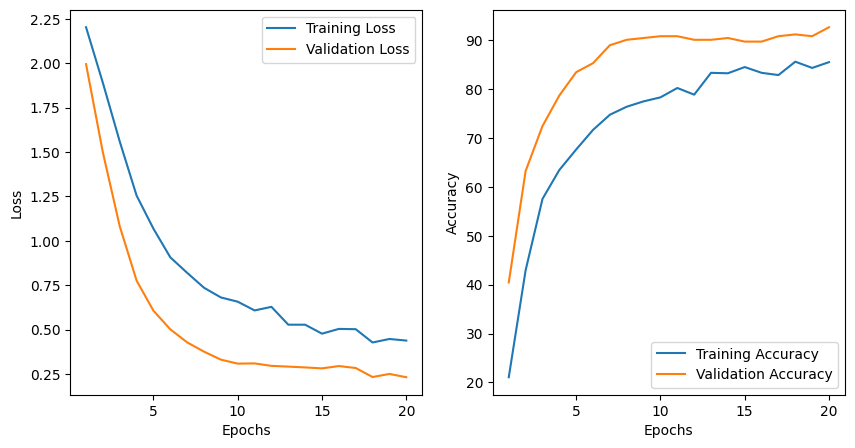

In [25]:
plt.figure(figsize = (10,5))

# plot loss
plt.subplot(1,2,1)
plt.plot(range(1, trainConfig.num_epochs+1), train_losses, label = "Training Loss")
plt.plot(range(1, trainConfig.num_epochs+1), val_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# plot accuracy
plt.subplot(1,2,2)
plt.plot(range(1, trainConfig.num_epochs+1), train_accuracies, label = "Training Accuracy")
plt.plot(range(1, trainConfig.num_epochs+1), val_accuracies, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# Save and load best model weights

In [27]:
# Load the best model weights
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

# Inference

In [28]:
def prediction(model, val_loader):
    """
    Generates predictions using the trained model on validation data.

    Parameters:
    model (torch.nn.Module): The trained neural network model.
    val_loader (DataLoader): The DataLoader for validation data.

    Returns:
    tuple: Arrays containing images, true labels, predicted labels, and prediction probabilities.
    """

    model.eval()
    model.to(device)

    all_images, all_labels, all_preds, all_probs = [], [], [], []

    with torch.inference_mode():
        for images, labels in tqdm(val_loader, desc="Inference"):
            images, labels = images.to(device) , labels.to(device)
            output = model(images)

            prob = F.softmax(output, dim = 1)
            pred = prob.data.max(dim = 1)[1]
            pred_probs = prob.data.max(dim =1)[0]

            all_images.append(images.cpu())
            all_labels.append(labels.cpu())
            all_preds.append(pred.cpu())
            all_probs.append(pred_probs.cpu())

        return (
        torch.cat(all_images).numpy(),  # Convert list of images to NumPy array
        torch.cat(all_labels).numpy(),  # Convert list of labels to NumPy array
        torch.cat(all_preds).numpy(),  # Convert list of predicted labels to NumPy array
        torch.cat(all_probs).numpy()  # Convert list of prediction probabilities to NumPy array
    )

In [29]:
def denormalize(image):
    """
    Reverses the normalization process applied during image preprocessing.

    Parameters:
    image (numpy.ndarray or torch.Tensor): The normalized image array.

    Returns:
    numpy.ndarray: The denormalized image array with values clipped between 0 and 1.
    """
    mean_ar = np.array(mean)  # Convert mean list to NumPy array
    std_ar = np.array(std)  # Convert standard deviation list to NumPy array

    image = image * std_ar + mean_ar  # Reverse normalization transformation
    return np.clip(image, 0, 1)  # Clip values to ensure they remain within the valid range [0,1]

In [38]:
def visualise_predictions(sample_images, sample_gt_labels, pred_indices, pred_probs, num_images=10):
    """
    Visualizes sample images along with their ground truth and predicted labels.

    Parameters:
    sample_images (numpy.ndarray): Array of sample images.
    sample_gt_labels (numpy.ndarray): Ground truth labels for the images.
    pred_indices (numpy.ndarray): Predicted class indices.
    pred_probs (numpy.ndarray): Prediction probabilities.
    num_images (int): Number of images to visualize.
    """

    fig = plt.figure(figsize=(40, 5))

    for i in range(num_images):
        idx = random.randint(0, len(sample_images) -1)
        image = sample_images[idx].transpose(1,2,0)
        label = sample_gt_labels[idx]
        pred_idx = pred_indices[idx]
        pred_prob = pred_probs[idx]

        image = denormalize(image)

        ax = fig.add_subplot(1, num_images, i + 1, xticks=[], yticks=[])
        ax.imshow(image, cmap='gray')
        ax.set_title(f"GT: {class_mapping[label]}, Pred: {class_mapping[pred_idx]} ({pred_prob:.2f})")
        ax.axis(False)

    plt.show()

Inference: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


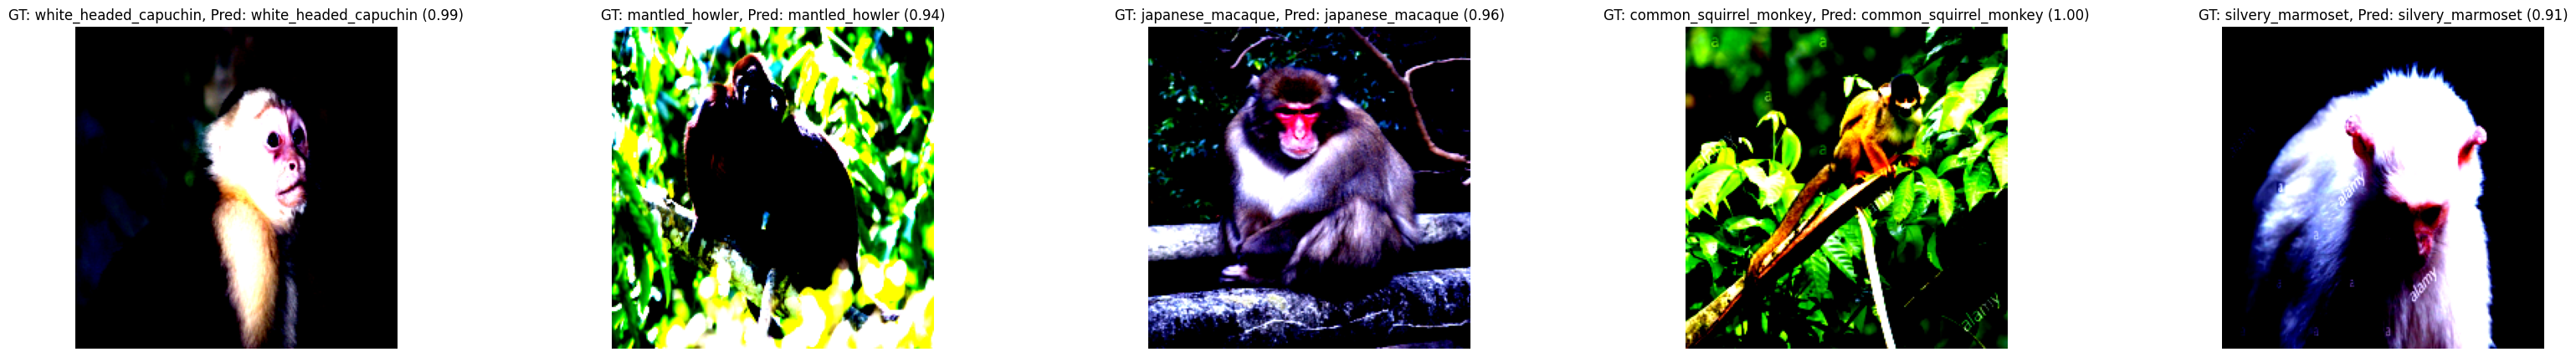

In [39]:
# Generate predictions using the trained model on the validation dataset
val_images, val_gt_labels, pred_indices, pred_probs = prediction(model, val_loader)

# Visualize a subset of the predictions
visualise_predictions(val_images, val_gt_labels, pred_indices, pred_probs, num_images=5)

## Confusion Matrix

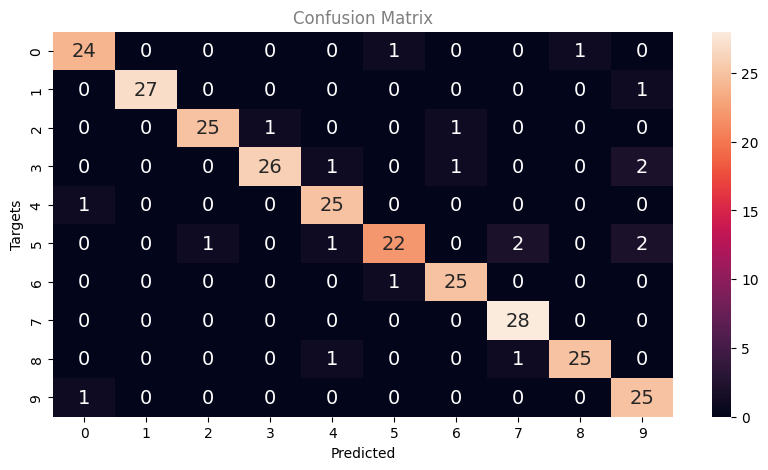

In [40]:
# Compute the confusion matrix based on ground truth labels and model predictions
cm = confusion_matrix(y_true=val_gt_labels, y_pred=pred_indices)

# Create a figure for the confusion matrix
plt.figure(figsize=(10,5))

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})  # Display numerical values in the heatmap

# Label the axes
plt.xlabel("Predicted")  # X-axis represents predicted classes
plt.ylabel("Targets")  # Y-axis represents actual (ground truth) classes

# Set the title for the confusion matrix plot
plt.title(f"Confusion Matrix", color="gray")

# Display the plot
plt.show()